# StubHub Ticket Pricing Optimization for Effective Arbitrage
### A.K.A. ScalperBot™ 🤖

## <i>Arbitrage</i> is the behavior of buying in one market and simultaneously selling in another, profiting from a temporary difference. 

#### This project began with the goal of identifying the optimal characteristics for the sale of tickets via StubHub. After a bit of research and EDA, the conversation quickly became, "What if you could use machine learning to optimize the purchase and resale of tickets for profit?" I'm just beginning to dig into this alternative concept.

#### Aside from this being an otherwise legally questionable concept, this has the potential to be monetized through revealing the key features and pricing attributes to customers of the resale market.

#### This could also be adopted by StubHub directly.<br>StubHub could identify profitable tickets, retail them as 'StubHub Certified', and enjoy the new revenue.

#### This report utilizes a dataset for Fireworks Night at the San Francisco Giants AT&T Park, May 27, 2017.

## I know what you're thinking.<br>"Wait, this looks an awful lot like your concert analysis."<br>You're correct. Most of this process is fortunately plug and play.

# Setting Up Shop

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf

# Offline toggle for Plot.ly / Cufflinks
# cf.go_offline()

# Online toggle for Plot.ly / Cufflinks
cf.go_online()

from sklearn.model_selection import cross_val_score, train_test_split, KFold, ShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNetCV, LassoCV, RidgeCV
from sklearn.metrics import r2_score
import seaborn as sns
import scipy.stats as stats
from ipywidgets import *
from timeit import default_timer as timer

pd.set_option('chained_assignment',None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing and Cleaning the Data

In [2]:
column_names = [
        'currentPrice', 'deliveryMethodList', 'deliveryTypeList',
        'dirtyTicketInd', 'faceValue', 'listingAttributeCategoryList',
        'listingAttributeList', 'listingId', 'listingPrice', 'quantity',
        'row', 'score', 'seatNumbers', 'sectionId', 'sectionName',
        'sellerOwnInd', 'sellerSectionName', 'splitOption',
        'splitVector', 'ticketSplit', 'zoneId', 'zoneName',
        'current_price', 'listing_price', 'profit', 'date'
]

In [3]:
concert = pd.read_csv('./sports_tickets.csv', names=column_names, header=None, \
                      error_bad_lines=False, low_memory=False)

concert.columns = column_names
concert = concert.sort_values(['listingId'], ascending=True)

In [4]:
# Removing the malformed data... :-/

concert.drop(concert[(concert['dirtyTicketInd'] != 'False') & \
        (concert['dirtyTicketInd'] != 'True')].index, inplace=True)

concert.drop(concert[concert['listingId'].map(len) < 10].index, inplace=True)
concert.drop(concert[concert['listingId'].map(len) > 10].index, inplace=True)
concert.reset_index(drop=True, inplace=True)

In [5]:
concert.shape

(356000, 26)

In [6]:
# Paring down the features

concert = concert[['currentPrice', 'dirtyTicketInd', 'faceValue', 'listingId', 'listingPrice', \
                   'quantity', 'row', 'score', 'sectionId', 'sectionName', 'splitOption', \
                   'splitVector', 'zoneId', 'zoneName', 'current_price', 'listing_price', \
                   'profit', 'date']]

In [7]:
# Creating two DataFrames: one for initial listings,
# and one for final listings.

concert_firsts = concert.drop_duplicates(['listingId'], keep='first')
concert_lasts = concert.drop_duplicates(['listingId'], keep='last')

In [8]:
# Combining the two DataFrames and resetting the index

concert_cleaned = concert_firsts.append(concert_lasts)
concert_cleaned = concert_cleaned.reset_index(drop = True)

In [9]:
# There are a few bad rows, each first/last for individual
# listings that need to be dropped

drop_index = concert_cleaned[concert_cleaned.currentPrice.isnull() == True].index
concert_cleaned.drop(concert_cleaned.index[drop_index], inplace=True)
concert_cleaned = concert_cleaned.reset_index(drop = True)

In [10]:
# Converting the date column to datetime and extracting the day of week

concert_cleaned['date'] = pd.to_datetime(concert_cleaned['date'], infer_datetime_format=True)
concert_cleaned['day_of_week'] = concert_cleaned['date'].dt.weekday_name

In [11]:
concert_cleaned.shape

(3296, 19)

In [12]:
# Current date of the pulled CSV is May 28, 2017
# I need to remove postings from within the past 24 hours
# to ensure relevance in the analysis.
# Otherwise, a listing from within the past 12 hours
# will become a count of 0 days.
# 0 days can still be a valid count for tickets that sell quickly,
# so it has to be preserved.

In [13]:
drop_index = concert_cleaned[concert_cleaned['date'] > '2017-05-27'].index

concert_cleaned.drop(concert_cleaned.index[drop_index], inplace=True)
concert_cleaned = concert_cleaned.reset_index(drop = True)

In [14]:
# Removing non-duplicate rows.
# Valid listings should have a start and stop, regardless if a sale
# or a stagnant ticket.

drop_index = concert_cleaned[concert_cleaned.duplicated('listingId', keep=False) == False].index

concert_cleaned.drop(concert_cleaned.index[drop_index], inplace=True)
concert_cleaned = concert_cleaned.reset_index(drop = True)

# Separating Out Sales Date Ranges

In [15]:
# Sort the cleaned DataFrame by listingId and calculate the difference in
# the dates between the first listing and the last listing for a listing age

concert_cleaned = concert_cleaned.sort_values(['listingId','date'])
concert_cleaned['age'] = concert_cleaned['date'].diff()
concert_cleaned.reset_index(drop=True, inplace=True)

In [16]:
# Setting the first listing date (even numbered rows) to a NaN for clarity
# and then converting the listing age to a whole number

concert_cleaned['age'].iloc[::2] = None
concert_cleaned['age'] = concert_cleaned['age'].dt.days

In [17]:
# Creating a sample set to evaluate listing ages

sample_set = concert_cleaned.groupby(['age']).count()
sample_set = pd.DataFrame(sample_set['zoneId']).copy()
sample_set.columns = ['Quantity']

sample_set['Sales'] = sample_set['Quantity'].diff()
sample_set.ix[sample_set['Sales'] > 0, 'Sales'] = 0
sample_set['Sales'] = sample_set['Sales'].abs()

sample_set.set_value(0, 'Sales', 783)
sample_set.T

/Users/noun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,20.0,22.0,23.0,24.0,26.0,27.0,29.0,30.0,31.0,32.0
Quantity,945.0,162.0,69.0,38.0,26.0,23.0,14.0,22.0,6.0,11.0,...,3.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0
Sales,783.0,783.0,93.0,31.0,12.0,3.0,9.0,0.0,16.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [18]:
# This shows us that our oldest unsold tickets are around 32 days,
# and our oldest sold tickets are around 31 days.

max_age = 32

In [22]:
# Let's plot out the listing ages.

fig1 = sample_set.iplot(kind='line', theme='white', asFigure=True)
fig2 = sample_set.iplot(kind='line', theme='white', asFigure=True)

layout = go.Layout(
    title='Listing Ages and Sales<br>Concert Tickets',
    xaxis=dict(title='Age'),
    yaxis=dict(title='Total Listings / Total Sales'),
)

fig2['data'].extend(fig1['data'])
data=fig2['data']
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# Which Zone is Which?

In [19]:
concert_cleaned.zoneId.unique()

array([ 46347,  46348,  46345,  47485,  46329,  46343,  46327,  46339,
       262038, 265997,  46346,  46338, 253556, 104914,  46344,  47552])

In [20]:
# ZoneID 46327 =  zoneName Arcade                         - fv: $44  | mean lp: ~$28
# ZoneID 46329 =  zoneName Bleachers                      - fv: $32  | mean lp: ~$25
# ZoneId 46338 =  zoneName Lower Box                      - fv: $67  | mean lp: ~$27
# ZoneId 46339 =  zoneName Lower Box Left Field           - fv: $40  | mean lp: ~$27
# ZoneId 46343 =  zoneName View Box                       - fv: $37  | mean lp: ~$27
# ZoneId 46344 =  zoneName View Box Left Field            - fv: $37  | mean lp: ~$28
# zoneId 46345 =  zoneName View Reserve Infield           - fv: $30  | mean lp: ~$24
# ZoneId 46346 =  zoneName View Reserve Left Field        - fv: $31  | mean lp: ~$22
# ZoneId 46347 =  ZoneName View Reserve Outfield          - fv: $22  | mean lp: ~$22
# ZoneId 46348 =  ZoneName View Reserve Right Field       - fv: $24  | mean lp: ~$22
# ZoneId 47485 =  zoneName Center Field Bleachers         - fv: $26  | mean lp: ~$24
# ZoneId 47552 =  zoneName Club Level Left Field          - fv: $44  | mean lp: ~$28
# ZoneId 104914 = zoneName SRO                            - fv: $17  | mean lp: ~$19
# ZoneId 253556 = zoneName Premium Bleachers A            - fv: $36  | mean lp: ~$30
# ZoneId 262038 = zoneName Premium Bleachers              - fv: $36  | mean lp: ~$27
# ZoneId 265997 = zoneName Premium Center Field Bleachers - fv: $26  | mean lp: ~$26

In [21]:
# Let's remove any other oddities:
zone_odds = concert_cleaned[concert_cleaned['zoneId'].isnull()].index.values
zone_odds

array([], dtype=int64)

In [22]:
concert_cleaned.drop(zone_odds, axis=0, inplace=True)
concert_cleaned.reset_index(drop=True, inplace=True)

In [23]:
# Creating an Average Face Value column to calculate the profit target

zones = {
    'View Reserve Outfield': 22, 
    'View Reserve Right Field': 24,
    'View Reserve Infield': 30, 
    'Center Field Bleachers': 26, 
    'Bleachers': 32,
    'View Box': 37, 
    'Arcade': 44, 
    'Lower Box Left Field': 40, 
    'Premium Bleachers': 36,
    'Premium Bleachers Center Field': 26, 
    'View Reserve Left Field': 31,
    'Lower Box': 67, 
    'Bleachers A': 36, 
    'SRO': 17, 
    'View Box Left Field': 37,
    'Club Level Left Field': 44
}
    

concert_cleaned['avg_face_val'] = concert_cleaned['zoneName']
concert_cleaned = concert_cleaned.replace({'avg_face_val':zones})

In [24]:
concert_cleaned['avg_face_val'][concert_cleaned.avg_face_val == 'View Reseve Right Field'] = 24
concert_cleaned['avg_face_val'] = pd.to_numeric(concert_cleaned['avg_face_val'])

In [25]:
# This data set includes two pricing columns:
# one column to reflect the listing price plus Stubhub fees and
# one column to reflect the listing price.

# I've defined Profit to the seller as the listing_price minus the face value of the ticket,
# a sunk cost, and minus 10%, which is the fee a seller pays upon sale of the ticket. 

# Value is calculated as the current price, which includes the service fees to the buyer, 
# minus the face value of the ticket (the intrinsic value). This is essentially the markup. 
# I divide this by the average face value to calculate a ratio between the markup
# and the intrinsic value of the ticket.

concert_cleaned['current_price'] = pd.to_numeric(concert_cleaned['current_price'])
concert_cleaned['listing_price'] = pd.to_numeric(concert_cleaned['listing_price'])
concert_cleaned['value'] = (concert_cleaned['current_price'] - concert_cleaned['avg_face_val']) \
                            / concert_cleaned['avg_face_val']
concert_cleaned['profit'] = concert_cleaned['listing_price'] - \
                            concert_cleaned['avg_face_val'] - \
                            (concert_cleaned['listing_price'] * .1)

# ART!

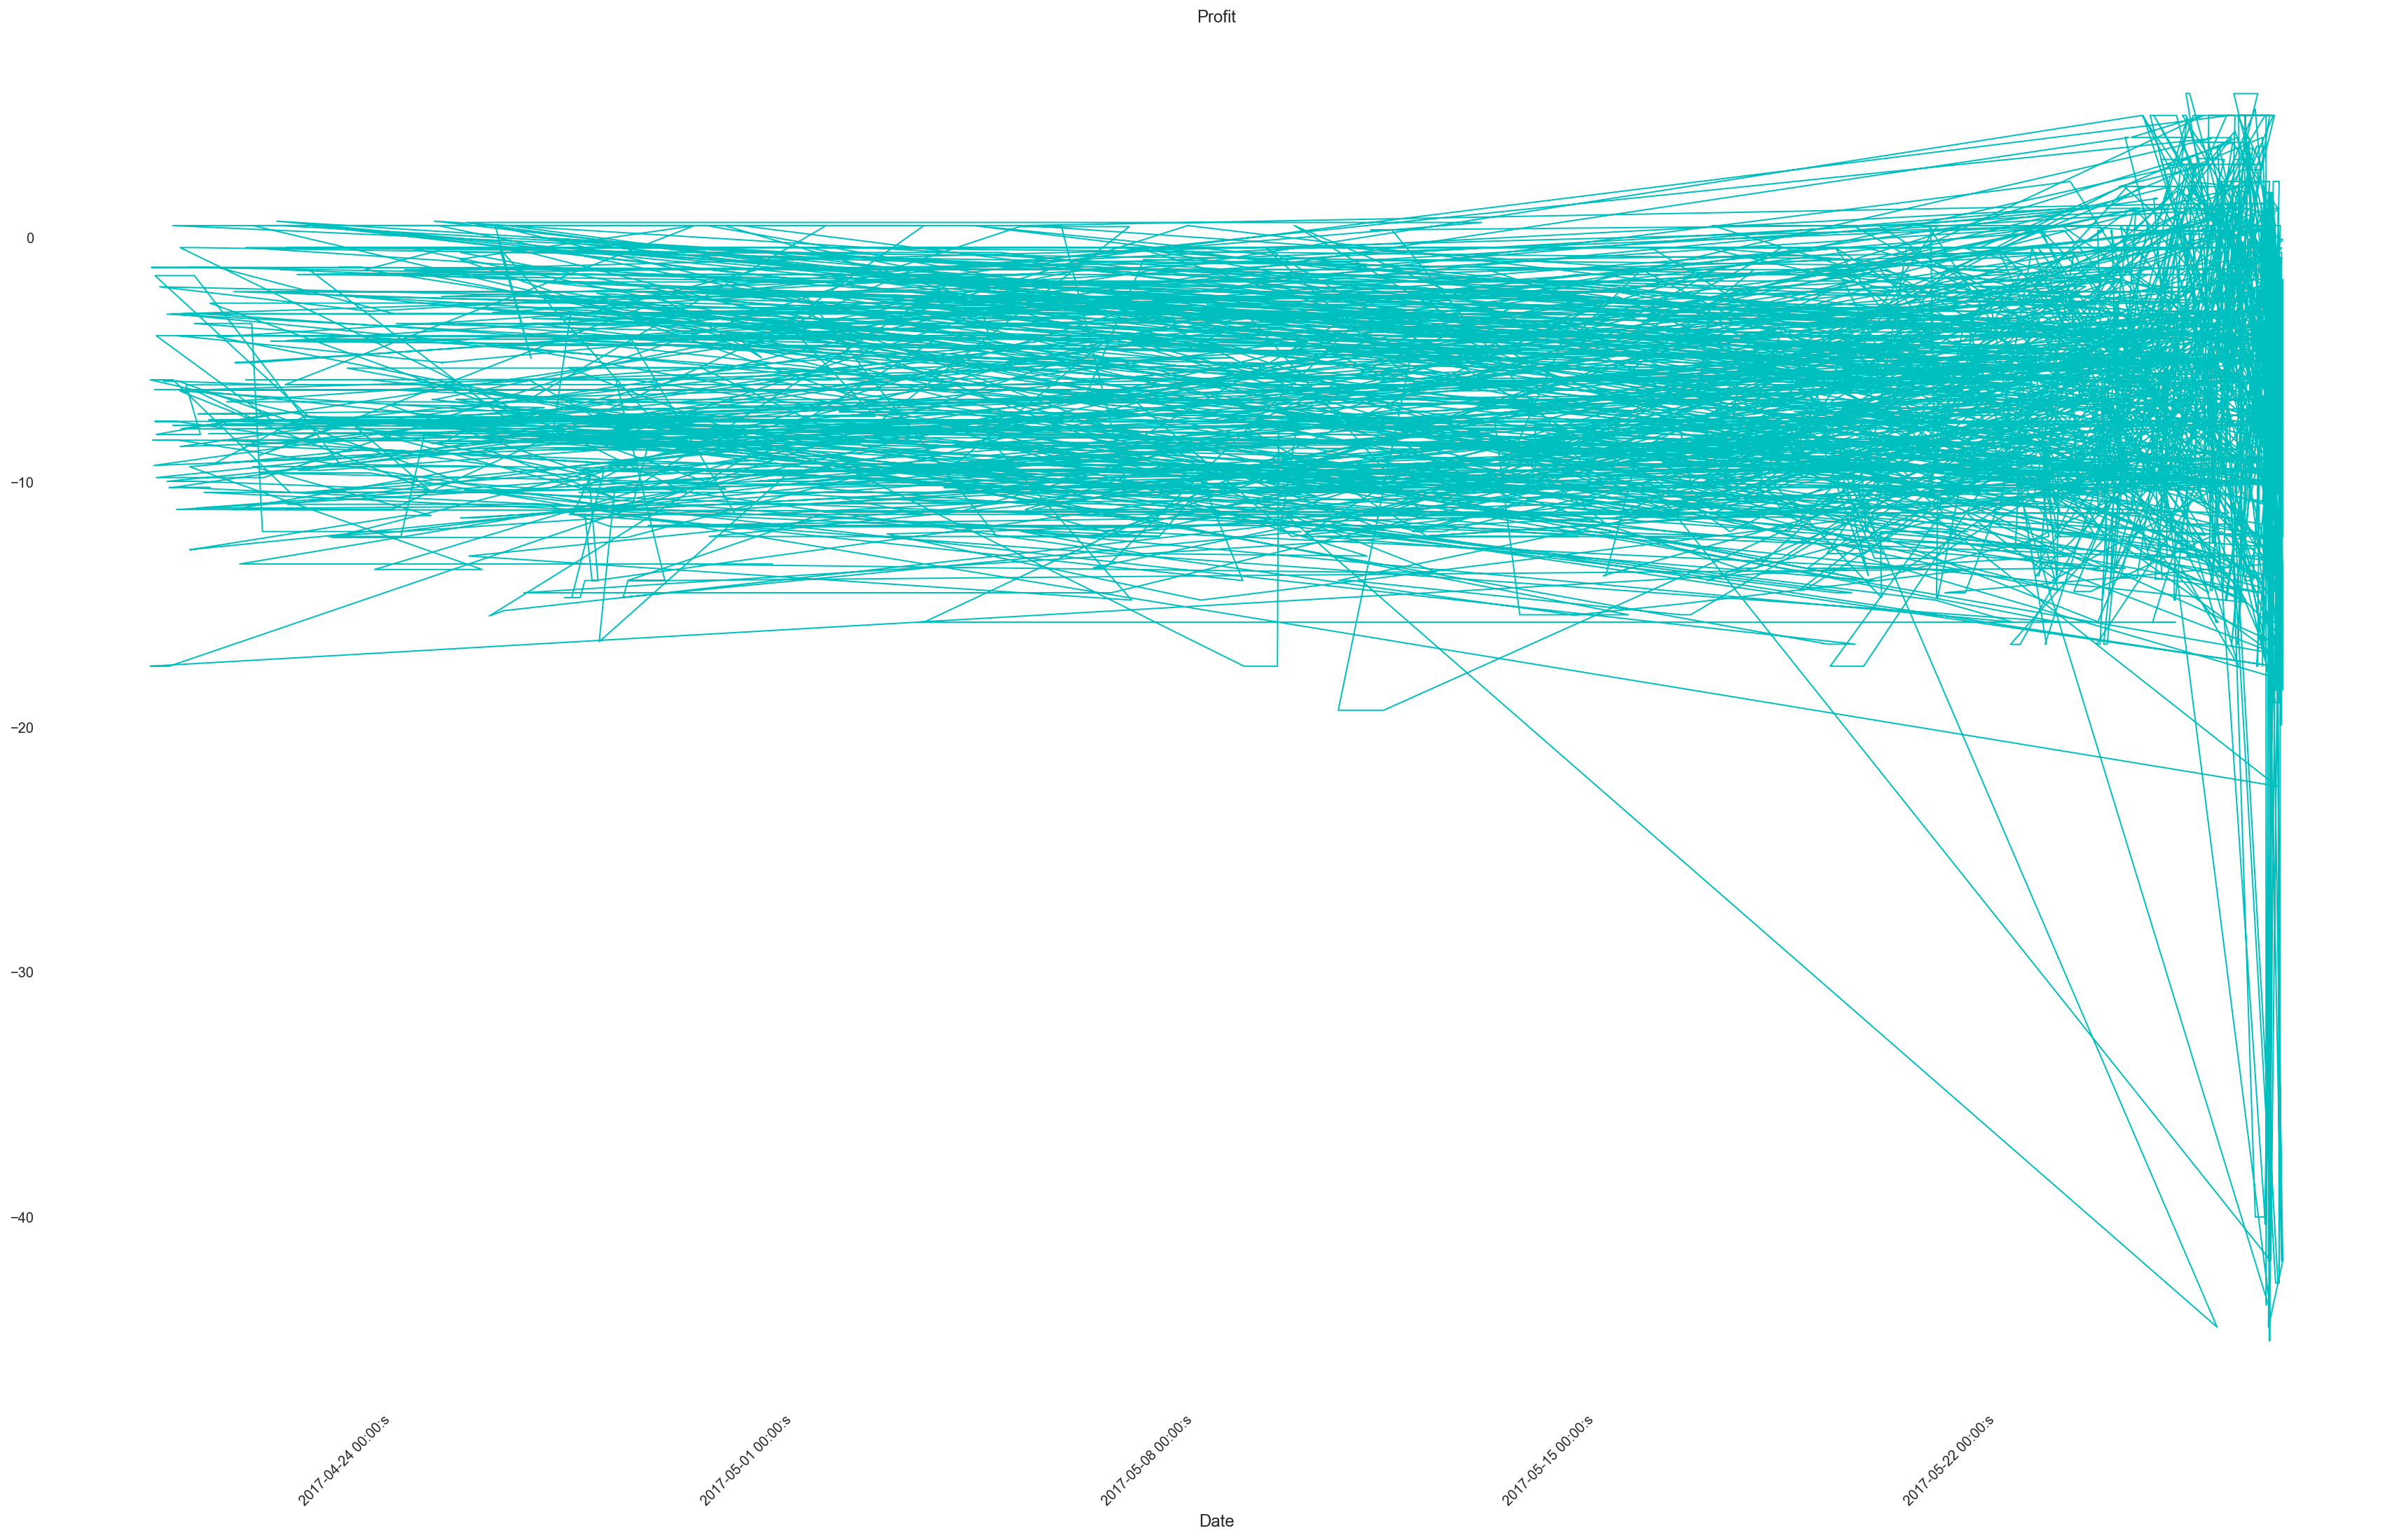

In [74]:
# This ultimately doesn't tell us anything, but it looks neat!! (∪´>‿<`)

y = concert_cleaned.profit
t = concert_cleaned.date
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(1, 1, 1, facecolor='white')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%s'))

ax1.plot(t, y, 'c', linewidth=1)
plt.title('Profit')
plt.xlabel('Date', fontsize='large')
fig.autofmt_xdate(rotation=45)

# Min/Max by Date Ranges

In [31]:
date_range_p = concert_cleaned[['date', 'age', 'listing_price', 'profit', 'current_price', 'value', 'listingId']]
date_range_p = date_range_p[date_range_p['age'] < max_age]

date_range_p.drop(['listingId', 'age'], axis=1, inplace=True)
date_range_p['date'] = date_range_p['date'].dt.date
date_range_p.sort_values('date', inplace=True)

date_range_p_min = date_range_p.pivot_table(index='date', aggfunc='min')
date_range_v_min = date_range_p_min[['current_price', 'value']]
date_range_p_min.drop(['current_price', 'value'], axis=1, inplace=True)
date_range_p_min.columns
date_range_p_min.columns = ['Minimum Sold Price', 'Minimum Profit']
date_range_v_min.columns = ['Minimum Sale Price', 'Maximum Value']

date_range_p_max = date_range_p.pivot_table(index='date', aggfunc='max')
date_range_v_max = date_range_p_max[['current_price', 'value']]
date_range_p_max.drop(['current_price', 'value'], axis=1, inplace=True)
date_range_p_max.columns = ['Maximum Sold Price', 'Maximum Profit']
date_range_v_max.columns = ['Maximum Sale Price', 'Minimum Value']

date_range_p_minmax = pd.concat([date_range_p_min, date_range_p_max], axis=1)
date_range_v_minmax = pd.concat([date_range_v_min, date_range_v_max], axis=1)
date_range_v_minmax.loc[:,'Minimum Value'] *= -1
date_range_v_minmax.loc[:,'Maximum Value'] *= -1

In [34]:
date_range_p_minmax[['Minimum Sold Price', 'Maximum Sold Price']].iplot(kind='area', \
                   fill='True', theme='white', margin=(88,5), \
                   title='Sports Ticket Sold Price<br>by Listing Date', \
                   xTitle='Date', yTitle='Dollars')

In [35]:
date_range_p_minmax[['Minimum Profit', 'Maximum Profit']].iplot(kind='line', \
                   fill='True', theme='white', margin=(88,5), \
                   title='Sports Ticket Profit<br>by Listing Date', \
                   xTitle='Date', yTitle='Dollars')

In [36]:
date_range_v_minmax[['Minimum Sale Price', 'Maximum Sale Price']].iplot(kind='area', \
                   fill='True', theme='white', margin=(88,5), \
                   title='Sports Ticket Sale Price<br>by Listing Date', \
                   xTitle='Date', yTitle='Dollars')

In [38]:
date_range_v_minmax.loc[:,'Minimum Value'] *= -1
date_range_v_minmax.loc[:,'Maximum Value'] *= -1
date_range_v_minmax[['Maximum Value', 'Minimum Value']].iplot(kind='line', \
                   fill='True', theme='white', margin=(88,5), \
                   title='Sports Ticket Value<br>by Listing Date', \
                   xTitle='Date', yTitle='Value')

# Min/Max by Listing

In [84]:
listing_range_p = concert_cleaned[['listingId', 'age', 'listing_price', 'profit']]
listing_range_p = listing_range_p[listing_range_p['age'] < max_age]
listing_range_p.drop('age', axis=1, inplace=True)
listing_range_p.sort_values('listingId', inplace=True)

listing_range_p = listing_range_p.pivot_table(index='listingId')
listing_range_p.columns = ['Sold Price', 'Profit']
listing_range_p.T

listingId,1226849436,1226849557,1226849590,1226849613,1226849635,1226867388,1227622718,1227628375,1227630479,1227636231,...,1259255576,1259256390,1259257613,1259258632,1259259591,1259260290,1259260323,1259260693,1259261987,1259263633
Sold Price,23.130,23.130,19.110,25.140,20.110,25.0,22.730,23.930,22.140,21.910,...,20.0,19.0,26.0,25.990,14.0,16.0,13.950,22.0,17.0,16.90
Profit,-1.183,-3.183,-4.801,0.626,-3.901,0.5,-9.543,-8.463,-6.074,-6.281,...,-8.0,-19.9,-8.6,-8.609,-11.4,-17.6,-4.445,-12.2,-1.7,-1.79


In [85]:
listing_range_p.iplot(kind='line', theme='white', margin=(88,5), \
                      title='Sports Ticket Sold Price and Profit<br>by Listing ID', \
                      xTitle='Sequential Listing ID', yTitle='Dollars')

# Min/Max Profit by Day of Week

In [39]:
day_of_week_p = concert_cleaned[['profit', 'day_of_week', 'age']]
day_of_week_p = day_of_week_p[day_of_week_p['age'] < max_age]
day_of_week_p.drop('age', axis=1, inplace=True)

day_of_week_p.sort_values('day_of_week', inplace=True)

day_of_week_min = day_of_week_p.pivot_table(index='day_of_week', aggfunc='min')
day_of_week_min.columns = ['Minimum Profit']

day_of_week_max = day_of_week_p.pivot_table(index='day_of_week', aggfunc='max')
day_of_week_max.columns = ['Maximum Profit']

day_of_week_minmax = pd.concat([day_of_week_min, day_of_week_max], axis=1)

day_of_week_minmax = day_of_week_minmax.T

ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_of_week_minmax = day_of_week_minmax[ordered_days]
day_of_week_minmax

day_of_week,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
Minimum Profit,-15.4,-16.609,-17.5,-15.7,-44.5,-45.058,-14.800
Maximum Profit,0.5,0.500,1.2,5.0,5.9,5.891,0.626


In [40]:
day_of_week_minmax.iplot(kind='box', \
                           theme='white', margin=(88,5), \
                           title='Sports Ticket Minimum and Maximum Profit<br>by Day of Week', \
                           xTitle='Day of Week', yTitle='Dollars')

# Evaluating Profit by Time of Day

In [41]:
bins = [-1, 6, 11, 17, 20, 25]
bin_names = ['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']

time_of_day_p_range = concert_cleaned[['profit', 'date', 'age']]
time_of_day_p_range['time_hour'] = time_of_day_p_range['date'].dt.hour
categories = pd.cut(time_of_day_p_range['time_hour'], bins, labels=bin_names)
time_of_day_p_range['time_of_day'] = pd.cut(time_of_day_p_range['time_hour'], bins, labels=bin_names)
time_of_day_p_range = time_of_day_p_range[time_of_day_p_range['age'] < max_age]
time_of_day_p_range.drop(['date', 'age', 'time_hour'], axis=1, inplace=True)

time_of_day_p_range.sort_values('time_of_day', inplace=True)

time_of_day_p_min = time_of_day_p_range.pivot_table(index='time_of_day', aggfunc='min')
time_of_day_p_min.columns = ['Minimum Profit']

time_of_day_p_max = time_of_day_p_range.pivot_table(index='time_of_day', aggfunc='max')
time_of_day_p_max.columns = ['Maximum Profit']

time_of_day_p_minmax = pd.concat([time_of_day_p_min, time_of_day_p_max], axis=1)

In [42]:
time_of_day_p_minmax = time_of_day_p_minmax.T

ordered_time = ['Morning', 'Afternoon', 'Evening', 'Night', 'Late Night']
time_of_day_p_minmax = time_of_day_p_minmax[ordered_time]
time_of_day_p_minmax

time_of_day,Morning,Afternoon,Evening,Night,Late Night
Minimum Profit,-19.3,-44.500,-45.058,-42.7,-17.5
Maximum Profit,5.9,5.891,5.000,5.0,5.0


In [43]:
time_of_day_p_minmax.iplot(kind='box', margin=(88,5), \
                             title='Sports Ticket Minimum and Maximum Profit<br>by Time of Day', \
                             theme='white', xTitle='Time of Day', yTitle='Dollars', mean=True)

# Evaluating by Auction Launch Date

In [93]:
first_range = concert_cleaned[['listingId', 'date', 'age', 'listing_price', 'profit', 'current_price', 'value']]
first_range = first_range[first_range['age'] < max_age]
first_range.drop('listingId', axis=1, inplace=True)
first_range.drop('age', axis=1, inplace=True)
first_range.reset_index(drop=True, inplace=True)

first_range['date'] = pd.to_datetime(first_range['date']).dt.date

first_range.sort_values('date', inplace=True)

first_mins = first_range.pivot_table(index='date', aggfunc='min')
first_mins.columns = ['Minimum Listing Price', 'Minimum Sold Price',
                      'Minimum Profit', 'Maximum Value']
first_maxs = first_range.pivot_table(index='date', aggfunc='max')
first_maxs.columns = ['Maximum Listing Price', 'Maximum Sold Price',
                      'Maximum Profit', 'Minimum Value']

first_listed_minmax = pd.concat([first_mins['Minimum Listing Price'], \
                                 first_maxs['Maximum Listing Price']], axis=0)
                        
first_sold_minmax = pd.concat([first_mins['Minimum Sold Price'], \
                               first_maxs['Maximum Sold Price']], axis=0)

first_collected = pd.concat([first_listed_minmax, first_sold_minmax], axis=1)

In [94]:
first_sold_minmax.sort_index(inplace=True)
first_collected.columns = ['Min/Max Sale Price', 'Min/Max Sold Price']

In [96]:
first_collected.iplot(kind='bar', barmode='group', margin=(88,5), \
                      title='Sports Ticket Minimum and Maximum<br>Sale Price / Sold Price by Date', \
                      theme='white', xTitle='Date', yTitle='Dollars')

# Evaluating Profit by Listing Hour

In [97]:
hour_range = concert_cleaned[['listingId', 'date', 'age', 'listing_price', 'current_price']]
hour_range = hour_range[hour_range['age'] < max_age]
hour_range.drop('listingId', axis=1, inplace=True)
hour_range.drop('age', axis=1, inplace=True)
hour_range.reset_index(drop=True, inplace=True)

hour_range['hour'] = hour_range['date'].dt.hour
hour_range.drop('date', axis=1, inplace=True)
hour_range.sort_values('hour', inplace=True)

hour_mins = hour_range.pivot_table(index='hour', aggfunc='min')
hour_mins.columns = ['Minimum Listing Price', 'Minimum Sold Price']
hour_maxs = hour_range.pivot_table(index='hour', aggfunc='max')
hour_maxs.columns = ['Maximum Listing Price', 'Maximum Sold Price']

hour_range_final = pd.concat([hour_mins, hour_maxs], axis=1)
hour_range_final.T

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Minimum Listing Price,23.89,22.22,21.55,22.72,22.72,23.89,23.39,24.38,24.56,27.09,...,21.55,21.78,21.05,21.55,24.56,24.15,21.43,21.9,22.16,19.82
Minimum Sold Price,17.00,16.00,15.00,16.00,16.00,17.00,17.00,17.85,18.00,20.00,...,15.00,15.20,15.00,15.00,18.00,17.22,14.90,15.3,15.95,13.95
Maximum Listing Price,38.72,38.60,39.77,39.10,40.28,39.76,40.06,39.77,40.13,39.77,...,38.60,39.71,38.60,38.60,38.60,38.60,38.60,38.6,38.60,38.60
Maximum Sold Price,30.10,30.00,31.00,30.00,31.44,30.99,31.25,31.00,31.31,31.00,...,30.00,30.95,30.00,30.00,30.00,30.00,30.00,30.0,30.00,30.00


In [98]:
hour_range_final.iplot(kind='line', filename='profit_by_listing_hour', margin=(88,5), \
                 title='Sports Ticket Minimum / Maximum Sale Price and Sold Price<br>by Hour of Day', \
                 theme='white', xTitle='Listing Hour', yTitle='Dollars')

# Evaluating Profit by Zone

In [151]:
# ZoneID 46327 =  zoneName Arcade                         - fv: $44  | mean lp: ~$28
# ZoneID 46329 =  zoneName Bleachers                      - fv: $32  | mean lp: ~$25
# ZoneId 46338 =  zoneName Lower Box                      - fv: $67  | mean lp: ~$27
# ZoneId 46339 =  zoneName Lower Box Left Field           - fv: $40  | mean lp: ~$27
# ZoneId 46343 =  zoneName View Box                       - fv: $37  | mean lp: ~$27
# ZoneId 46344 =  zoneName View Box Left Field            - fv: $37  | mean lp: ~$28
# zoneId 46345 =  zoneName View Reserve Infield           - fv: $30  | mean lp: ~$24
# ZoneId 46346 =  zoneName View Reserve Left Field        - fv: $31  | mean lp: ~$22
# ZoneId 46347 =  ZoneName View Reserve Outfield          - fv: $22  | mean lp: ~$22
# ZoneId 46348 =  ZoneName View Reserve Right Field       - fv: $24  | mean lp: ~$22
# ZoneId 47485 =  zoneName Center Field Bleachers         - fv: $26  | mean lp: ~$24
# ZoneId 47552 =  zoneName Club Level Left Field          - fv: $44  | mean lp: ~$28
# ZoneId 104914 = zoneName SRO                            - fv: $17  | mean lp: ~$19
# ZoneId 253556 = zoneName Premium Bleachers A            - fv: $36  | mean lp: ~$30
# ZoneId 262038 = zoneName Premium Bleachers              - fv: $36  | mean lp: ~$27
# ZoneId 265997 = zoneName Premium Center Field Bleachers - fv: $26  | mean lp: ~$26

In [107]:
zone_range_p = concert_cleaned[['zoneName', 'age', 'profit', 'value']]
zone_range_p = zone_range_p[zone_range_p['age'] < max_age]
zone_range_p.drop('age', axis=1, inplace=True)

zone_range_p_min = zone_range_p.pivot_table(index='zoneName', aggfunc='min')
zone_range_p_min.columns = ['Minimum Profit', 'Maximum Value']
zone_range_v_min = zone_range_p_min[['Maximum Value']]
zone_range_p_min.drop('Maximum Value', axis=1, inplace=True)

zone_range_p_max = zone_range_p.pivot_table(index='zoneName', aggfunc='max')
zone_range_p_max.columns = ['Maximum Profit', 'Minimum Value']
zone_range_v_max = zone_range_p_max['Minimum Value']
zone_range_p_max.drop('Minimum Value', axis=1, inplace=True)

zone_range_p_minmax = pd.concat([zone_range_p_min, zone_range_p_max], axis=1)
zone_range_v_minmax = pd.concat([zone_range_v_min, zone_range_v_max], axis=1)

In [108]:
zone_range_profit_minmax = zone_range_p_minmax[['Minimum Profit', 'Maximum Profit']]
zone_range_profit_minmax = zone_range_profit_minmax.T

In [46]:
zone_range_profit_minmax.iplot(kind='box', theme='white', \
                    margin=(88,5), \
                    title='Sports Ticket Minimum / Maximum Profit by Zone', \
                    xTitle='Zone', yTitle='Dollars')

In [111]:
# zone_range_v_minmax = zone_range_v_minmax.T

zone_range_v_minmax.loc[:,'Minimum Value'] *= -1
zone_range_v_minmax.loc[:,'Maximum Value'] *= -1

zone_range_v_minmax[['Minimum Value', 'Maximum Value']].iplot(kind='bar',  \
                    margin=(88,5), \
                    theme='white', title='Sports Ticket Mean Average Value by Zone', \
                    xTitle='Zone')

# What is the mean average listing price / sale price and profit / value by zone for tickets sold within the first / two / five / ten days from listing?

In [53]:
oned_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
oned_zone_range_min = oned_zone_range_min[oned_zone_range_min['age'] < 2]
oned_zone_range_min.drop('age', axis=1, inplace=True)       
                                
oned_zone_range_min = oned_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

oned_zone_range_min.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
current_price,31.58,22.22,38.6,26.9,36.7,32.02,30.91,26.9,29.24,19.82,25.73,36.26,21.55,21.05,21.55,19.88


In [54]:
oned_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
oned_zone_range_p = oned_zone_range_p[oned_zone_range_p['age'] < 2]
oned_zone_range_p.drop('age', axis=1, inplace=True)

oned_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
oned_zone_range_v = oned_zone_range_v[oned_zone_range_v['age'] < 2]
oned_zone_range_v.drop('age', axis=1, inplace=True)

oned_zone_range_v = oned_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

oned_zone_range_p = oned_zone_range_p.groupby('zoneName').mean()
oned_zone_range_p['volume'] = oned_zone_range_v['current_price']
oned_zone_range_p.drop('value', axis=1, inplace=True)
oned_zone_range_p['minimum_price'] = oned_zone_range_min['current_price']

In [55]:
oned_zone_range_p = oned_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [56]:
oned_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [58]:
oned_zone_range_p.iplot(kind='bar', barmode='group', theme='white', \
                   title='Sports Ticket Sale Price / Purchase Behavior Within The First Day', \
                   xTitle='Zone', yTitle='Dollars / Total')

In [59]:
twoed_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
twoed_zone_range_min = twoed_zone_range_min[twoed_zone_range_min['age'] < 3]
twoed_zone_range_min.drop('age', axis=1, inplace=True)        
                                
twoed_zone_range_min = twoed_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

twoed_zone_range_min.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
current_price,31.58,22.22,38.6,26.9,36.7,32.02,30.91,26.9,29.24,19.82,25.73,36.26,21.55,21.05,21.55,19.88


In [60]:
twoed_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
twoed_zone_range_p = twoed_zone_range_p[twoed_zone_range_p['age'] < 3]
twoed_zone_range_p.drop('age', axis=1, inplace=True)

twoed_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
twoed_zone_range_v = twoed_zone_range_v[twoed_zone_range_v['age'] < 3]
twoed_zone_range_v.drop('age', axis=1, inplace=True)

twoed_zone_range_v = twoed_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

twoed_zone_range_p = twoed_zone_range_p.groupby('zoneName').mean()

twoed_zone_range_p['volume'] = twoed_zone_range_v['current_price']
twoed_zone_range_p.drop('value', axis=1, inplace=True)
twoed_zone_range_p['minimum_price'] = twoed_zone_range_min['current_price']

In [61]:
twoed_zone_range_p = twoed_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [62]:
twoed_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [63]:
fived_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
fived_zone_range_min = fived_zone_range_min[fived_zone_range_min['age'] < 6]
fived_zone_range_min.drop('age', axis=1, inplace=True)       
                                
fived_zone_range_min = fived_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

fived_zone_range_min.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
current_price,31.58,22.22,38.6,26.9,36.7,32.02,30.91,26.9,29.24,19.82,25.73,36.26,21.55,21.05,21.55,19.88


In [64]:
fived_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
fived_zone_range_p = fived_zone_range_p[fived_zone_range_p['age'] < 6]
fived_zone_range_p.drop('age', axis=1, inplace=True)

fived_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
fived_zone_range_v = fived_zone_range_v[fived_zone_range_v['age'] < 6]
fived_zone_range_v.drop('age', axis=1, inplace=True)
fived_zone_range_v = fived_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

fived_zone_range_p = fived_zone_range_p.groupby('zoneName').mean()

fived_zone_range_p['volume'] = fived_zone_range_v['current_price']
fived_zone_range_p.drop('value', axis=1, inplace=True)
fived_zone_range_p['minimum_price'] = fived_zone_range_min['current_price']

In [44]:
fived_zone_range_p = fived_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [45]:
fived_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [46]:
fived_zone_range_p.iplot(kind='bar', barmode='group', theme='white', \
                   title='Sports Ticket Sale Price / Purchase Behavior Within Five Days', \
                   xTitle='Zone', yTitle='Dollars / Total')

In [65]:
tend_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
tend_zone_range_min = tend_zone_range_min[tend_zone_range_min['age'] < 11]
tend_zone_range_min.drop('age', axis=1, inplace=True)       
                                
tend_zone_range_min = tend_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

tend_zone_range_min.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
current_price,31.58,22.22,38.6,26.9,36.7,32.02,30.91,26.9,29.24,19.82,25.73,36.26,21.55,21.05,21.55,19.88


In [66]:
tend_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
tend_zone_range_p = tend_zone_range_p[tend_zone_range_p['age'] < 11]
tend_zone_range_p.drop('age', axis=1, inplace=True)

tend_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
tend_zone_range_v = tend_zone_range_v[tend_zone_range_v['age'] < 11]
tend_zone_range_v.drop('age', axis=1, inplace=True)
tend_zone_range_v = tend_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

tend_zone_range_p = tend_zone_range_p.groupby('zoneName').mean()
tend_zone_range_p['volume'] = tend_zone_range_v['current_price']
tend_zone_range_p.drop('value', axis=1, inplace=True)
tend_zone_range_p['minimum_price'] = tend_zone_range_min['current_price']

In [67]:
tend_zone_range_p = tend_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [68]:
tend_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [69]:
twent_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
twent_zone_range_min = twent_zone_range_min[twent_zone_range_min['age'] < 21]
twent_zone_range_min.drop('age', axis=1, inplace=True)     
                            
twent_zone_range_min = twent_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

twent_zone_range_min.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
current_price,31.58,22.22,38.6,26.9,36.7,32.02,30.91,26.9,29.24,19.82,25.73,36.26,21.55,21.05,21.55,19.88


In [70]:
twent_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
twent_zone_range_p = twent_zone_range_p[twent_zone_range_p['age'] < 21]
twent_zone_range_p.drop('age', axis=1, inplace=True)

twent_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
twent_zone_range_v = twent_zone_range_v[twent_zone_range_v['age'] < 21]
twent_zone_range_v.drop('age', axis=1, inplace=True)
twent_zone_range_v = twent_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

twent_zone_range_p = twent_zone_range_p.groupby('zoneName').mean()
twent_zone_range_p['volume'] = twent_zone_range_v['current_price']
twent_zone_range_p.drop('value', axis=1, inplace=True)
twent_zone_range_p['minimum_price'] = twent_zone_range_min['current_price']

In [71]:
twent_zone_range_p = twent_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [72]:
twent_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [73]:
twent_zone_range_r = pd.DataFrame()

twent_zone_range_r['Total Revenue'] = twent_zone_range_p['Average Profit'] * \
                                      twent_zone_range_p['Total Quantity Sold']

In [74]:
thirt_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
thirt_zone_range_min = thirt_zone_range_min[thirt_zone_range_min['age'] < 31]
thirt_zone_range_min.drop('age', axis=1, inplace=True)     
                            
thirt_zone_range_min = thirt_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

thirt_zone_range_min.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
current_price,31.58,22.22,38.6,26.9,36.7,32.02,30.91,26.9,29.24,19.82,25.73,36.26,21.55,21.05,21.55,19.88


In [75]:
thirt_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
thirt_zone_range_p = thirt_zone_range_p[thirt_zone_range_p['age'] < 31]
thirt_zone_range_p.drop('age', axis=1, inplace=True)

thirt_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
thirt_zone_range_v = thirt_zone_range_v[thirt_zone_range_v['age'] < 31]
thirt_zone_range_v.drop('age', axis=1, inplace=True)
thirt_zone_range_v = thirt_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

thirt_zone_range_p = thirt_zone_range_p.groupby('zoneName').mean()
thirt_zone_range_p['volume'] = thirt_zone_range_v['current_price']
thirt_zone_range_p.drop('value', axis=1, inplace=True)
thirt_zone_range_p['minimum_price'] = thirt_zone_range_min['current_price']

In [76]:
thirt_zone_range_p = thirt_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [77]:
thirt_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [78]:
thirt_zone_range_r = pd.DataFrame()

thirt_zone_range_r['Total Revenue'] = thirt_zone_range_p['Average Profit'] * \
                                      thirt_zone_range_p['Total Quantity Sold']

In [142]:
thirt_zone_range_p.iplot(kind='bar', barmode='group', theme='white', \
                   margin=(88,5), \
                   title='Sports Ticket Sale Price / Purchase Behavior<br>First Thirty Days', \
                   xTitle='Zone', yTitle='Dollars / Total')

In [79]:
thirt_zone_range_r.T.iplot(kind='barh', theme='white', margin=(88,5), \
                           xTitle='Dollars',
                           title='Sports Tickets Total Revenue Over 30 Days<br>by Zone')

# What is the volume of tickets sold by zone within the first / two / five / ten days from listing?

In [144]:
one_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
one_v_zone_range = one_v_zone_range[one_v_zone_range['age'] < 2]
one_v_zone_range.drop('age', axis=1, inplace=True)
one_v_zone_range = one_v_zone_range.groupby('zoneName').count()

one_v_zone_range.columns = ['Count']
one_v_zone_range.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
Count,4,235,1,77,1,14,45,36,16,12,52,1,290,25,191,107


In [145]:
two_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
two_v_zone_range = two_v_zone_range[two_v_zone_range['age'] < 3]
two_v_zone_range.drop('age', axis=1, inplace=True)
two_v_zone_range = two_v_zone_range.groupby('zoneName').count()

two_v_zone_range.columns = ['Count']
two_v_zone_range.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
Count,4,246,1,81,1,14,45,37,16,12,52,1,318,26,204,118


In [146]:
five_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
five_v_zone_range = five_v_zone_range[five_v_zone_range['age'] < 6]
five_v_zone_range.drop('age', axis=1, inplace=True)
five_v_zone_range = five_v_zone_range.groupby('zoneName').count()

five_v_zone_range.columns = ['Count']
five_v_zone_range.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
Count,4,258,1,86,1,14,45,37,17,12,54,1,342,29,235,127


In [147]:
ten_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
ten_v_zone_range = ten_v_zone_range[ten_v_zone_range['age'] < 11]
ten_v_zone_range.drop('age', axis=1, inplace=True)
ten_v_zone_range = ten_v_zone_range.groupby('zoneName').count()

ten_v_zone_range.columns = ['Count']
ten_v_zone_range.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
Count,4,266,1,89,1,14,45,37,17,12,55,1,352,30,260,144


In [151]:
twenty_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
twenty_v_zone_range = twenty_v_zone_range[twenty_v_zone_range['age'] < 21]
twenty_v_zone_range.drop('age', axis=1, inplace=True)
twenty_v_zone_range = twenty_v_zone_range.groupby('zoneName').count()

twenty_v_zone_range.columns = ['Count']
twenty_v_zone_range.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
Count,4,272,1,93,1,14,45,37,17,12,55,1,360,32,287,156


In [152]:
thirty_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
thirty_v_zone_range = thirty_v_zone_range[thirty_v_zone_range['age'] < 31]
thirty_v_zone_range.drop('age', axis=1, inplace=True)
thirty_v_zone_range = thirty_v_zone_range.groupby('zoneName').count()

thirty_v_zone_range.columns = ['Count']
thirty_v_zone_range.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
Count,4,272,1,94,1,14,45,37,17,12,55,1,363,32,293,156


In [153]:
one_two_five_ten = pd.DataFrame()
one_two_five_ten['One Day'] = one_v_zone_range['Count']
one_two_five_ten['Two Days'] = two_v_zone_range['Count']
one_two_five_ten['Five Days'] = five_v_zone_range['Count']
one_two_five_ten['Ten Days'] = ten_v_zone_range['Count']
one_two_five_ten['Twenty Days'] = twenty_v_zone_range['Count']
one_two_five_ten['Thirty Days'] = thirty_v_zone_range['Count']
one_two_five_ten.T

zoneName,Arcade,Bleachers,Bleachers A,Center Field Bleachers,Club Level Left Field,Lower Box,Lower Box Left Field,Premium Bleachers,Premium Bleachers Center Field,SRO,View Box,View Box Left Field,View Reserve Infield,View Reserve Left Field,View Reserve Outfield,View Reseve Right Field
One Day,4,235,1,77,1,14,45,36,16,12,52,1,290,25,191,107
Two Days,4,246,1,81,1,14,45,37,16,12,52,1,318,26,204,118
Five Days,4,258,1,86,1,14,45,37,17,12,54,1,342,29,235,127
Ten Days,4,266,1,89,1,14,45,37,17,12,55,1,352,30,260,144
Twenty Days,4,272,1,93,1,14,45,37,17,12,55,1,360,32,287,156
Thirty Days,4,272,1,94,1,14,45,37,17,12,55,1,363,32,293,156


In [154]:
one_two_five_ten.iplot(kind='bar', theme='white', \
                       title='Total Number of Sports Tickets Sold<br>by Zone', \
                       margin=(88,5), \
                       xTitle='Zone', yTitle='Number Sold')

# Profit is our target. 

## The more accurately we can predict profit, the better we can maximize the potential for continuous profitability in 'flipping tickets'. 🥞

# Correlations 👯

In [27]:
concert_keep = ['zoneName', 'quantity','splitOption','sectionId','zoneId','listing_price', \
                'current_price','day_of_week', 'profit', 'value', 'age']
concert_analysis = concert_cleaned[concert_keep]
concert_analysis['quantity'] = pd.to_numeric(concert_analysis['quantity']).astype(float).copy()
concert_analysis['splitOption'] = pd.to_numeric(concert_analysis['splitOption']).astype(float).copy()
concert_analysis['sectionId'] = pd.to_numeric(concert_analysis['sectionId']).astype(float).copy()
concert_analysis['zoneId'] = pd.to_numeric(concert_analysis['zoneId']).astype(float).copy()
concert_dummies = pd.get_dummies(concert_analysis[['day_of_week', 'zoneName']]).astype(float)
concert_analysis.drop(['day_of_week', 'zoneName'], axis=1, inplace=True)
concert_analysis = concert_analysis.join(concert_dummies)

In [28]:
corr = concert_analysis.corr()

corr.iplot(kind='heatmap', title='Sports Ticket Correlation Matrix', theme='white', margin=(155,5))

# Model Setup 💻

In [30]:
concert_keep = ['quantity','zoneId','listing_price', \
                'day_of_week', 'age', 'profit']
concert_analysis = concert_cleaned[concert_keep]
concert_cleaned['age'][concert_cleaned.age.isnull() == True] = 0
concert_analysis['quantity'] = pd.to_numeric(concert_analysis['quantity']).astype(float).copy()
concert_analysis['zoneId'] = pd.to_numeric(concert_analysis['zoneId']).astype(float).copy()
concert_dummies = pd.get_dummies(concert_analysis['day_of_week']).astype(float)
concert_analysis.drop('day_of_week', axis=1, inplace=True)
concert_analysis = concert_analysis.join(concert_dummies)

In [31]:
X = concert_analysis
y = concert_analysis['profit']
X.drop('profit', axis=1, inplace=True)

In [32]:
# break up the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [33]:
print 'X train shape: ', X_train.shape
print 'y train shape: ', y_train.shape
print 'X test shape', X_test.shape
print 'y test shape: ', y_test.shape

X train shape:  (1400, 11)
y train shape:  (1400,)
X test shape (1400, 11)
y test shape:  (1400,)


# Let's try all the things! 😸
# Target: Profit

## Identifying Coefficients with LassoCV

In [34]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [35]:
model_lasso = LassoCV(n_alphas=100, selection='random', max_iter=15000).fit(X_train, y_train)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 6.0085347405039489)
('Min: ', 5.0466780343514186)


In [36]:
lasso_df = concert_analysis
l_coef = pd.Series(model_lasso.coef_, index = lasso_df.columns)
print("Lasso picked " + str(sum(l_coef != 0)) + " variables and eliminated the other " +  str(sum(l_coef == 0)) + " variables")

Lasso picked 1 variables and eliminated the other 10 variables


In [37]:
lasso_coef = pd.concat([l_coef.sort_values().head(10),
                        l_coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
lasso_coef.iplot(kind = "barh", theme='white', \
                 margin=(155,5), \
                 title='Coefficients in the Lasso Regression<br>Profit as Target')

## Identifying Coefficients with RidgeCV

In [38]:
model_ridge = RidgeCV(alphas=(0.01, 0.1, 1.0, 10, 100)).fit(X_train, y_train)
res = rmse_cv(model_ridge)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 5.8533948853474982)
('Min: ', 4.8554344726900771)


In [39]:
ridge_df = concert_analysis
r_coef = pd.Series(model_ridge.coef_, index = ridge_df.columns)
print("Ridge picked " + str(sum(r_coef != 0)) + " variables and eliminated the other " +  str(sum(r_coef == 0)) + " variables")

Ridge picked 11 variables and eliminated the other 0 variables


In [40]:
ridge_coef = pd.concat([r_coef.sort_values().head(10),
                        r_coef.sort_values().tail(10)])

ridge_coef.iplot(kind = "barh", theme='white', \
                 margin=(155,5), \
                 title='Coefficients in the Ridge Regression<br>Profit as Target')

## Identifying Coefficients with ElasticNetCV

In [41]:
model_en = ElasticNetCV(n_alphas=100, alphas=(0.01, 0.1, 1.0, 10, 100, 250, 500, 750, 1000), \
                        max_iter=15000, cv=5, n_jobs=-1).fit(X_train, y_train)
res = rmse_cv(model_en)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 5.8556007972037021)
('Min: ', 4.8589097312513561)


In [42]:
en_df = concert_analysis
en_coef = pd.Series(model_en.coef_, index = en_df.columns)
print("ElasticNet picked " + str(sum(en_coef != 0)) + " variables and eliminated the other " +  str(sum(en_coef == 0)) + " variables")

ElasticNet picked 7 variables and eliminated the other 4 variables


In [43]:
elasn_coef = pd.concat([en_coef.sort_values().head(10),
                      en_coef.sort_values().tail(10)])

elasn_coef.iplot(kind = "barh", theme='white', 
                 margin=(155,5), \
                 title='Coefficients in the ElasticNet Regression<br>Profit as Target')

## The ElasticNet response shows that a few days of the week are suboptimal.
## So, let's remove those and try a Linear Regression.

In [44]:
lr = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)

lr.fit(X_train, y_train)

pred_lr_profit = pd.DataFrame()
pred_lr_profit['Predicted Profit'] = lr.predict(X_test)
scores = cross_val_score(lr, X_test, y_test, cv=5)

lr_profit_score = '5-Fold CV Mean Average: {percent:.2%}'.format(percent=scores.mean())
lr_profit_std = 'Standard Deviation: {percent:.2%}'.format(percent=scores.std() * 2)
lr_profit_r2 = 'R^2 score: {percent:.2%}'.format(percent=r2_score(y_test, lr.predict(X_test)))

print lr_profit_score
print lr_profit_std
print lr_profit_r2

5-Fold CV Mean Average: 3.42%
Standard Deviation: 5.29%
R^2 score: 4.42%


In [45]:
true_profit = pd.DataFrame(y_test.astype(float))
true_profit.columns = ['True Profit']
true_profit.reset_index(inplace=True, drop=True)

In [46]:
predicted_profit = pd.concat([pred_lr_profit, true_profit], axis=1)

In [47]:
predicted_profit.T

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
Predicted Profit,-3.08802,-9.557656,-6.616889,-7.050631,-7.163493,-4.059966,-9.05357,-5.247009,-5.586486,-6.433824,...,-7.77656,-6.471276,-6.460771,-8.036761,-5.347923,-6.694762,-8.00983,-6.332658,-6.981278,-9.417758
True Profit,-5.00000,-4.450000,-9.300000,-6.800000,-0.600000,-5.054000,-6.94500,-7.500000,-4.800000,-9.009000,...,-11.30000,-7.500000,-5.000000,-13.550000,-4.800000,-1.183000,-2.20000,-7.077000,-7.500000,-8.000000


In [48]:
predicted_profit.iplot(kind='spread', title='Linear Regression<br>Profit as Target', \
                       margin=(88,5), \
                       theme='white', xTitle=lr_profit_score, yTitle=lr_profit_std)

## Hyperparameter Optimization

In [49]:
# LR_parameters = {'copy_X':(True, False),
#                  'fit_intercept':(True, False),
#                  'normalize':(True, False)
#                 }

# RFR_parameters = {'n_estimators':(5,10,15,25,35,50),
#                   'criterion':('mae', 'mse'),
#                   'bootstrap':(True, False),
# #                   'oob_score':(True, False),
#                   'warm_start':(True,False)
#                   }

# ABR_parameters = {'n_estimators':(10,15,20,50,75,100),
#                   'learning_rate':(1,2,3,4,5),
#                   'loss':('linear','square','exponential')
#                  }

# BR_parameters = {'n_iter':(5,10,15,25,50,75,100),
#                  'compute_score':(True,False),
#                  'fit_intercept':(True,False),
#                  'normalize':(True,False),
#                  'copy_X':(True,False)
#                 }

# KNN_parameters = {'n_neighbors':(2,3,4,5,6,7,8),
#                   'weights':('uniform', 'distance'),
#                   'algorithm':('ball_tree', 'kd_tree', 'brute'),
#                   'metric':('minkowski', 'euclidean', 'manhattan', 'chebyshev')
#                  }

# only_the_best = GridSearchCV(LinearRegression(), LR_parameters, verbose=1, cv=5, n_jobs=-1)
# only_the_best.fit(X_train, y_train)
# only_the_best.best_estimator_ 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

## Scoring with Cross Validation

In [50]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

cross_p_mean = []
cross_p_std = []
cross_p_r2 = []
cross_p_time = []

cross_p_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(X_train, y_train)
    cross_p_predictions[other_rgs] = other_rgs.predict(X_test)
    
    
    start = timer()
    scores = cross_val_score(other_rgs, X_test, y_test, cv=5)
    cross_p_mean.append(scores.mean())
    cross_p_std.append(scores.std() * 2)
    cross_p_r2.append(r2_score(y_test, other_rgs.predict(X_test)))
    end = timer()
    cross_p_time.append(end-start)
    print '\n'

print '\n'
print '---\nShuffle Split Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(cross_p_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(cross_p_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(cross_p_r2))
print 'Time: ', end-start

print '\n'
    
print cross_p_mean, '\n'
print cross_p_std, '\n'
print cross_p_r2, '\n'
print cross_p_time, '\n'

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)




---
Shuffle Split Cross Validation Scores:
Mean Average: 54.94%
Standard 

In [51]:
cross_p_col_len = len(cross_p_predictions.columns)
cross_p_predictions.columns = np.arange(0, cross_p_col_len, 1)
cross_p_predictions

,0,1,2,3,4
0,-5.420000,-3.436798,-4.87040,-8.813300,-3.088020
1,-4.450000,-9.106789,-4.51660,-6.206526,-9.557656
2,-9.300000,-6.233763,-9.30000,-8.499344,-6.616889
3,-6.800000,-6.691270,-6.80000,-10.218306,-7.050631
4,-0.600000,-6.790119,-0.66444,-3.058708,-7.163493
5,-5.054000,-4.393066,-5.00900,-8.526133,-4.059966
6,-7.520027,-8.803918,-6.85644,-6.705481,-9.053570
7,-8.979600,-5.393958,-7.49784,-9.479568,-5.247009
8,-4.800000,-5.883673,-4.80792,-8.795477,-5.586486
9,-9.009000,-6.799259,-9.06768,-6.379500,-6.433824


## Scoring with KFolds

In [52]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

kfold_p_mean = []
kfold_p_std = []
kfold_p_r2 = []
kfold_p_time = []

kfold_p_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(X_train, y_train)
    kfold_p_predictions[other_rgs] = other_rgs.predict(X_test)
    
    cv = KFold(n_splits=3, shuffle=False, random_state=0)
    
    start = timer()
    scores = cross_val_score(other_rgs, X_test, y_test, cv=cv)
    kfold_p_mean.append(scores.mean())
    kfold_p_std.append(scores.std() * 2)
    kfold_p_r2.append(r2_score(y_test, other_rgs.predict(X_test)))
    end = timer()
    kfold_p_time.append(end-start)
    print '\n'

print '\n'
print '---\nKFold Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(kfold_p_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(kfold_p_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(kfold_p_r2))
print 'Time: ', end-start

print '\n'
    
print kfold_p_mean, '\n'
print kfold_p_std, '\n'
print kfold_p_r2, '\n'
print kfold_p_time, '\n'

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)




---
KFold Cross Validation Scores:
Mean Average: 53.37%
Standard Deviatio

In [53]:
kfold_p_col_len = len(kfold_p_predictions.columns)
kfold_p_predictions.columns = np.arange(0, kfold_p_col_len, 1)
kfold_p_predictions

,0,1,2,3,4
0,-5.420000,-3.436798,-4.89200,-8.892159,-3.088020
1,-4.450000,-9.106789,-4.44100,-6.111869,-9.557656
2,-9.300000,-6.233763,-9.30000,-9.434649,-6.616889
3,-6.800000,-6.691270,-6.80000,-10.188436,-7.050631
4,-0.600000,-6.790119,-0.72888,-2.083914,-7.163493
5,-5.054000,-4.393066,-5.00900,-8.892159,-4.059966
6,-7.520027,-8.803918,-6.97820,-6.891547,-9.053570
7,-8.979600,-5.393958,-7.50000,-9.098826,-5.247009
8,-4.800000,-5.883673,-4.80000,-7.980052,-5.586486
9,-9.009000,-6.799259,-9.02448,-7.376134,-6.433824


## Scoring by Shuffle Split

In [54]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

shuff_p_mean = []
shuff_p_std = []
shuff_p_r2 = []
shuff_p_time = []

shuff_p_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(X_train, y_train)
    shuff_p_predictions[other_rgs] = other_rgs.predict(X_test)
    
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=None)
    
    start = timer()
    scores = cross_val_score(other_rgs, X_test, y_test, cv=cv)
    shuff_p_mean.append(scores.mean())
    shuff_p_std.append(scores.std() * 2)
    shuff_p_r2.append(r2_score(y_test, other_rgs.predict(X_test)))
    end = timer()
    shuff_p_time.append(end-start)
    print '\n'

print '\n'
print '---\nShuffle Split Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(shuff_p_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(shuff_p_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(shuff_p_r2))
print 'Time: ', end-start

print '\n'
    
print shuff_p_mean, '\n'
print shuff_p_std, '\n'
print shuff_p_r2, '\n'
print shuff_p_time, '\n'

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)




---
Shuffle Split Cross Validation Scores:
Mean Average: 54.32%
Standard 

In [55]:
shuff_p_col_len = len(shuff_p_predictions.columns)
shuff_p_predictions.columns = np.arange(0, shuff_p_col_len, 1)
shuff_p_predictions

,0,1,2,3,4
0,-5.420000,-3.436798,-4.89200,-8.029182,-3.088020
1,-4.450000,-9.106789,-4.55728,-5.496871,-9.557656
2,-9.300000,-6.233763,-9.30000,-9.213731,-6.616889
3,-6.800000,-6.691270,-6.80000,-10.556923,-7.050631
4,-0.600000,-6.790119,-0.60000,-3.685025,-7.163493
5,-5.054000,-4.393066,-5.00900,-8.015164,-4.059966
6,-7.520027,-8.803918,-6.83052,-6.454390,-9.053570
7,-8.979600,-5.393958,-7.49784,-9.093378,-5.247009
8,-4.800000,-5.883673,-4.80000,-7.146293,-5.586486
9,-9.009000,-6.799259,-9.00864,-7.464967,-6.433824


# Chart it Out 😲📈

In [56]:
all_profit_mean_scores = pd.DataFrame()
all_profit_std_scores = pd.DataFrame()
all_profit_time_scores = pd.DataFrame()
all_profit_r2_scores = pd.DataFrame()

all_profit_mean_scores['5-Fold CV'] = cross_p_mean
all_profit_std_scores['5-Fold CV'] = cross_p_std
all_profit_time_scores['5-Fold CV'] = cross_p_time
all_profit_r2_scores['5-Fold CV'] = cross_p_r2

all_profit_mean_scores['KFold'] = kfold_p_mean
all_profit_std_scores['KFold'] = kfold_p_std
all_profit_time_scores['KFold'] = kfold_p_time
all_profit_r2_scores['KFold'] = kfold_p_r2

all_profit_mean_scores['Shuffle Split'] = shuff_p_mean
all_profit_std_scores['Shuffle Split'] = shuff_p_std
all_profit_time_scores['Shuffle Split'] = shuff_p_time
all_profit_r2_scores['Shuffle Split'] = shuff_p_r2

all_profit_mean_scores = all_profit_mean_scores.T
all_profit_std_scores = all_profit_std_scores.T
all_profit_time_scores = all_profit_time_scores.T
all_profit_r2_scores = all_profit_r2_scores.T

In [57]:
all_profit_mean_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                  'Linear']
all_profit_std_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                 'Linear']
all_profit_r2_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']
all_profit_time_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                  'Linear']

In [58]:
all_profit_mean_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.808135,0.033369,0.992299,0.878815,0.034159
KFold,0.764331,0.025655,0.975735,0.877730,0.025095
Shuffle Split,0.796363,0.042366,0.989183,0.870229,0.018038


In [59]:
all_profit_std_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.248960,0.043459,0.011276,0.064969,0.052876
KFold,0.087706,0.045382,0.030831,0.070251,0.052767
Shuffle Split,0.318580,0.059769,0.030093,0.086934,0.103282


In [60]:
all_profit_r2_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.798063,0.044446,0.998498,0.849788,0.044158
KFold,0.798063,0.044446,0.997804,0.850247,0.044158
Shuffle Split,0.798063,0.044446,0.998000,0.836110,0.044158


In [61]:
all_profit_time_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.126642,0.046976,1.279999,1.974476,0.027378
KFold,0.052464,0.021555,0.809897,1.167650,0.013516
Shuffle Split,0.105082,0.081141,2.365126,4.304711,0.041718


In [62]:
all_profit_mean_scores.T.iplot(kind='barh', fill=True, theme='white', \
                               margin=(88,5), \
                               title='Sports Ticket Mean Average Accuracy Scores<br>Profit as Target')

In [63]:
all_profit_std_scores.T.iplot(kind='barh', theme='white', \
                              margin=(88,5), \
                              title="Sports Ticket Model Standard Deviation<br>Profit as Target")

In [64]:
all_profit_time_scores.iplot(kind='barh', margin=(88,5), \
                             title='Sports Ticket Model Completion Time<br>Profit as Target', \
                             theme='white', xTitle='Time in Seconds<br>Lower is Better')

In [65]:
all_profit_r2_scores.T.iplot(kind='barh', title='Sports Ticket R<sup>2</sup> Score<br>Profit as Target', \
                             margin=(88,5), \
                             theme='white')

# 💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲

# Value is our target!

## The more accurately we can predict value, the greater likelihood for quick resale of desireable tickets. 📈

# Setup 💻

In [67]:
concert_keep = ['quantity','zoneId','current_price', \
                'day_of_week', 'age', 'value']
concert_analysis = concert_cleaned[concert_keep]
concert_cleaned['age'][concert_cleaned.age.isnull() == True] = 0
concert_analysis['quantity'] = pd.to_numeric(concert_analysis['quantity']).astype(float).copy()
concert_analysis['zoneId'] = pd.to_numeric(concert_analysis['zoneId']).astype(float).copy()
concert_dummies = pd.get_dummies(concert_analysis['day_of_week']).astype(float)
concert_analysis.drop('day_of_week', axis=1, inplace=True)
concert_analysis = concert_analysis.join(concert_dummies)

In [68]:
Xv = concert_analysis
yv = concert_analysis['value']
Xv.drop('value', axis=1, inplace=True)

In [69]:
# break up the data into train and test
Xv_train, Xv_test, yv_train, yv_test = train_test_split(Xv, yv, test_size=0.5)

In [70]:
print 'Xv train shape: ', Xv_train.shape
print 'yv train shape: ', yv_train.shape
print 'Xv test shape', Xv_test.shape
print 'yv test shape: ', yv_test.shape

Xv train shape:  (1400, 11)
yv train shape:  (1400,)
Xv test shape (1400, 11)
yv test shape:  (1400,)


# Let's try all the things... again! 😸
# Target: Value

## Identifying Coefficients with LassoCV

In [73]:
model_lassov = LassoCV(n_alphas=100, selection='random', max_iter=15000).fit(Xv_train, yv_train)
res = rmse_cv(model_lassov)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 0.21538417826843997)
('Min: ', 0.20186579148460662)


In [74]:
lasso_dfv = concert_analysis
lv_coef = pd.Series(model_lassov.coef_, index = lasso_dfv.columns)
print("Lasso picked " + str(sum(lv_coef != 0)) + " variables and eliminated the other " +  str(sum(lv_coef == 0)) + " variables")

Lasso picked 1 variables and eliminated the other 10 variables


In [75]:
lassov_coef = pd.concat([lv_coef.sort_values().head(10),
                         lv_coef.sort_values().tail(10)])

lassov_coef.iplot(kind = "barh", theme='white', \
                  margin=(155,5), \
                  title='Coefficients in the Lasso Regression<br>Value as Target')

## Identifying Coefficients with RidgeCV

In [76]:
model_ridgev = RidgeCV(alphas=(0.01, 0.1, 1.0, 10, 100)).fit(Xv_train, yv_train)
res = rmse_cv(model_ridgev)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 0.20362666363461299)
('Min: ', 0.19185745042771044)


In [77]:
ridgev_df = concert_analysis
rv_coef = pd.Series(model_ridgev.coef_, index = ridgev_df.columns)
print("Ridge picked " + str(sum(rv_coef != 0)) + " variables and eliminated the other " +  str(sum(rv_coef == 0)) + " variables")

Ridge picked 11 variables and eliminated the other 0 variables


In [78]:
ridgev_coef = pd.concat([rv_coef.sort_values().head(10),
                         rv_coef.sort_values().tail(10)])

ridgev_coef.iplot(kind = "barh", theme='white', \
                  margin=(155,5), \
                  title='Coefficients in the Ridge Regression<br>Value as Target')

## Identifying Coefficients with ElasticNetCV

In [79]:
model_env = ElasticNetCV(n_alphas=100, alphas=(0.01, 0.1, 1.0, 10, 100), \
                        max_iter=15000, cv=5, n_jobs=-1).fit(Xv_train, yv_train)
res = rmse_cv(model_env)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 0.20382593618831094)
('Min: ', 0.19113154079995973)


In [80]:
env_df = concert_analysis
env_coef = pd.Series(model_env.coef_, index = env_df.columns)
print("ElasticNet picked " + str(sum(env_coef != 0)) + " variables and eliminated the other " +  str(sum(env_coef == 0)) + " variables")

ElasticNet picked 5 variables and eliminated the other 6 variables


In [81]:
# Plotting the coefficients

elasnv_coef = pd.concat([env_coef.sort_values().head(10),
                        env_coef.sort_values().tail(10)])

elasnv_coef.iplot(kind = "barh", theme='white', \
                  margin=(155,5), \
                  title='Coefficients in the ElasticNet Regression<br>Value as Target')

## Again, the ElasticNet response shows me that a few days of the week are suboptimal.

# Linear Regression

In [89]:
lr = LinearRegression(copy_X=True, fit_intercept=True, normalize=True, n_jobs=-1)

lr.fit(Xv_train, yv_train)

pred_lr_value = pd.DataFrame()
pred_lr_value['Predicted Value'] = lr.predict(Xv_test)
scores = cross_val_score(lr, Xv_test, yv_test, cv=5)

lr_value_score = '5-Fold CV Mean Average: {percent:.2%}'.format(percent=scores.mean())
lr_value_std = 'Standard Deviation: {percent:.2%}'.format(percent=scores.std() * 2)
lr_value_r2 = 'R^2 score: {percent:.2%}'.format(percent=r2_score(yv_test, lr.predict(Xv_test)))

print lr_value_score
print lr_value_std
print lr_value_r2

5-Fold CV Mean Average: 10.04%
Standard Deviation: 4.94%
R^2 score: 10.99%


In [83]:
true_value = pd.DataFrame(yv_test.astype(float))
true_value.columns = ['True Value']
true_value.reset_index(inplace=True, drop=True)

In [84]:
predicted_value = pd.concat([pred_lr_value, true_value], axis=1)

In [85]:
predicted_value.T

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
Predicted Value,0.173274,0.155152,0.161795,0.221555,0.030257,0.147899,-0.054883,0.231752,-0.001657,0.177275,...,0.060324,0.120613,0.257484,0.093573,0.335953,0.215259,0.436229,0.173875,0.220437,0.077875
True Value,0.434167,0.169667,0.030333,0.039062,-0.037917,0.212308,-0.171667,0.060000,-0.092500,0.364583,...,-0.064333,0.052667,-0.049500,0.130000,0.349615,-0.043750,0.754545,0.007222,0.510833,0.245455


In [86]:
predicted_value.iplot(kind='spread', theme='white', \
                      title='Linear Regression with Value as Target', \
                      xTitle=lr_value_score, yTitle=lr_value_std)

## Scoring with Cross Validation

In [88]:
# LR_parameters = {'copy_X':(True, False),
#                  'fit_intercept':(True, False),
#                  'normalize':(True, False)
#                 }

# RFR_parameters = {'n_estimators':(5,10,15,25,35,50),
#                   'criterion':('mae', 'mse'),
#                   'bootstrap':(True, False),
# #                   'oob_score':(True, False),
#                   'warm_start':(True,False)
#                  }

# ABR_parameters = {'n_estimators':(10,15,20,50,75,100),
#                   'learning_rate':(1,2,3,4,5),
#                   'loss':('linear','square','exponential')
#                  }

# BR_parameters = {'n_iter':(5,10,15,25,50,75,100),
#                  'compute_score':(True,False),
#                  'fit_intercept':(True,False),
#                  'normalize':(True,False),
#                  'copy_X':(True,False)
#                 }

# KNN_parameters = {'n_neighbors':(2,3,4,5,6,7,8),
#                   'weights':('uniform', 'distance'),
#                   'algorithm':('ball_tree', 'kd_tree', 'brute'),
#                   'metric':('minkowski', 'euclidean', 'manhattan', 'chebyshev')
#                  }

# only_the_best = GridSearchCV(LinearRegression(), LR_parameters, verbose=1, cv=5, n_jobs=-1)
# only_the_best.fit(Xv_train, yv_train)
# only_the_best.best_estimator_ 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [91]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

cross_v_mean = []
cross_v_std = []
cross_v_r2 = []
cross_v_time = []

cross_v_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(Xv_train, yv_train)
    cross_v_predictions[other_rgs] = other_rgs.predict(Xv_test)
    
    start = timer()
    scores = cross_val_score(other_rgs, Xv_test, yv_test, cv=5)
    cross_v_mean.append(scores.mean())
    cross_v_std.append(scores.std() * 2)
    cross_v_r2.append(r2_score(yv_test, other_rgs.predict(Xv_test)))
    end = timer()
    cross_v_time.append(end-start)
    print '\n'
    
print '---\Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(cross_v_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(cross_v_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(cross_v_r2))
print 'Time: ', end-start
print '\n'

print cross_v_mean, '\n'
print cross_v_std, '\n'
print cross_v_r2, '\n'
print cross_v_time

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


---\Cross Validation Scores:
Mean Average: 58.91%
Standard Deviation: 3.07%

In [106]:
cross_v_col_len = len(cross_v_predictions.columns)
cross_v_predictions.columns = np.arange(0, cross_v_col_len, 1)
cross_v_predictions

,0,1,2,3,4
0,0.437292,0.186207,0.432816,0.381254,0.173274
1,0.158500,0.169029,0.169691,0.124771,0.155152
2,0.013667,0.148492,0.029984,0.045957,0.161795
3,0.023438,0.232296,0.039062,-0.009347,0.221555
4,0.076591,0.013611,-0.021295,0.098974,0.030257
5,0.216476,0.135475,0.211881,0.249373,0.147899
6,-0.171667,-0.048100,-0.121497,0.007899,-0.054883
7,0.023438,0.242511,0.059965,0.028143,0.231752
8,-0.015511,0.003020,-0.083042,0.039583,-0.001657
9,0.364375,0.160885,0.365306,0.360780,0.177275


## Scoring with KFolds

In [92]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

kfold_v_mean = []
kfold_v_std = []
kfold_v_r2 = []
kfold_v_time = []

kfold_v_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(Xv_train, yv_train)
    kfold_v_predictions[other_rgs] = other_rgs.predict(Xv_test)
    
    cv = KFold(n_splits=3, shuffle=False, random_state=None)
    
    start = timer()
    scores = cross_val_score(other_rgs, Xv_test, yv_test, cv=cv)
    kfold_v_mean.append(scores.mean())
    kfold_v_std.append(scores.std() * 2)
    kfold_v_r2.append(r2_score(yv_test, other_rgs.predict(Xv_test)))
    end = timer()
    kfold_v_time.append(end-start)
    print '\n'
    
print '---\nKFold Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(kfold_v_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(kfold_v_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(kfold_v_r2))
print 'Time: ', end-start
print '\n'
    
print kfold_v_mean, '\n'
print kfold_v_std, '\n'
print kfold_v_r2, '\n'
print kfold_v_time

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


---
KFold Cross Validation Scores:
Mean Average: 58.31%
Standard Deviation:

In [93]:
kfold_v_col_len = len(kfold_v_predictions.columns)
kfold_v_predictions.columns = np.arange(0, kfold_v_col_len, 1)
kfold_v_predictions

,0,1,2,3,4
0,0.437292,0.186207,0.426655,0.343145,0.173274
1,0.158500,0.169029,0.169688,0.127152,0.155152
2,0.013667,0.148492,0.030336,0.056394,0.161795
3,0.023438,0.232296,0.039062,0.050842,0.221555
4,0.076591,0.013611,-0.016462,0.090300,0.030257
5,0.216476,0.135475,0.214001,0.261416,0.147899
6,-0.171667,-0.048100,-0.135496,0.019119,-0.054883
7,0.023438,0.242511,0.059964,0.064407,0.231752
8,-0.015511,0.003020,-0.098929,0.030574,-0.001657
9,0.364375,0.160885,0.364447,0.338771,0.177275


## Scoring by Shuffle Split

In [94]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

shuff_v_mean = []
shuff_v_std = []
shuff_v_r2 = []
shuff_v_time = []

shuff_v_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(Xv_train, yv_train)
    shuff_v_predictions[other_rgs] = other_rgs.predict(Xv_test)
    
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=None)
    
    start = timer()
    scores = cross_val_score(other_rgs, Xv_test, yv_test, cv=cv)
    shuff_v_mean.append(scores.mean())
    shuff_v_std.append(scores.std() * 2)
    shuff_v_r2.append(r2_score(yv_test, other_rgs.predict(Xv_test)))
    end = timer()
    shuff_v_time.append(end-start)
    print '\n'
    
print '---\nShuffle Split Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(shuff_v_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(shuff_v_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(shuff_v_r2))
print 'Time: ', end-start        
print '\n'
    
print shuff_v_mean, '\n'
print shuff_v_std, '\n'
print shuff_v_r2, '\n'
print shuff_v_time

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


---
Shuffle Split Cross Validation Scores:
Mean Average: 57.76%
Standard De

In [95]:
shuff_v_col_len = len(shuff_v_predictions.columns)
shuff_v_predictions.columns = np.arange(0, shuff_v_col_len, 1)
shuff_v_predictions

,0,1,2,3,4
0,0.437292,0.186207,0.427245,0.363466,0.173274
1,0.158500,0.169029,0.169686,0.100189,0.155152
2,0.013667,0.148492,0.030424,0.057614,0.161795
3,0.023438,0.232296,0.039062,0.016128,0.221555
4,0.076591,0.013611,-0.007462,0.100901,0.030257
5,0.216476,0.135475,0.212037,0.263027,0.147899
6,-0.171667,-0.048100,-0.112913,0.001582,-0.054883
7,0.023438,0.242511,0.059967,0.016128,0.231752
8,-0.015511,0.003020,-0.111083,0.058370,-0.001657
9,0.364375,0.160885,0.364469,0.362540,0.177275


In [96]:
all_value_mean_scores = pd.DataFrame()
all_value_std_scores = pd.DataFrame()
all_value_time_scores = pd.DataFrame()
all_value_r2_scores = pd.DataFrame()

all_value_mean_scores['5-Fold CV'] = cross_v_mean
all_value_std_scores['5-Fold CV'] = cross_v_std
all_value_time_scores['5-Fold CV '] = cross_v_time
all_value_r2_scores['5-Fold CV'] = cross_v_r2

all_value_mean_scores['KFold'] = kfold_v_mean
all_value_std_scores['KFold'] = kfold_v_std
all_value_time_scores['KFold'] = kfold_v_time
all_value_r2_scores['KFold'] = kfold_v_r2

all_value_mean_scores['Shuffle Split'] = shuff_v_mean
all_value_std_scores['Shuffle Split'] = shuff_v_std
all_value_time_scores['Shuffle Split'] = shuff_v_time
all_value_r2_scores['Shuffle Split'] = shuff_v_r2

all_value_mean_scores = all_value_mean_scores.T
all_value_std_scores = all_value_std_scores.T
all_value_time_scores = all_value_time_scores.T
all_value_r2_scores = all_value_r2_scores.T

In [97]:
all_value_mean_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']
all_value_std_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']
all_value_time_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']
all_value_r2_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']

In [98]:
all_value_mean_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.888169,0.103144,0.981343,0.872545,0.100406
KFold,0.849104,0.108824,0.980652,0.868853,0.107961
Shuffle Split,0.874879,0.075402,0.981740,0.866534,0.089611


In [99]:
all_value_std_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.029738,0.044416,0.013042,0.016636,0.049444
KFold,0.005273,0.008754,0.010640,0.007166,0.003108
Shuffle Split,0.084551,0.124912,0.049975,0.022327,0.082672


In [100]:
all_value_r2_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.879216,0.110954,0.993635,0.864551,0.109945
KFold,0.879216,0.110954,0.991284,0.875472,0.109945
Shuffle Split,0.879216,0.110954,0.993846,0.883497,0.109945


In [101]:
all_value_time_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.105252,0.040665,1.410314,2.507562,0.031093
KFold,0.054872,0.024406,1.219663,1.965305,0.014292
Shuffle Split,0.162709,0.087425,2.478638,4.433808,0.043107


In [102]:
all_value_mean_scores.T.iplot(kind='barh', fill=True, theme='white', \
                              margin=(88,5), \
                              title='Sports Ticket Model Mean Average Accuracy Scores<br>Value as Target')

In [103]:
all_value_std_scores.T.iplot(kind='barh', theme='white', \
                             xTitle='Lower is Better', \
                             margin=(88,5), \
                             title="Sports Ticket Standard Deviation<br>Value as Target")

In [104]:
all_value_time_scores.iplot(kind='barh', theme='white', \
                            margin=(88,5), \
                            title='Sports Ticket Model Completion Time<br>Value as Target', \
                            xTitle='Time in Seconds<br>Lower is Better')

In [105]:
all_value_r2_scores.T.iplot(kind='barh', theme='white', \
                          margin=(88,5), \
                          title='Sports Ticket R<sup>2</sup> Score<br>Value as Target')